In [1]:
import pandas as pd
df = pd.read_csv('../../csv/regioni/veneto.csv')
df.head()

,DATA,TOTALE
0,2015-01-31,5009
1,2015-02-28,4121
2,2015-03-31,4225
3,2015-04-30,3806
4,2015-05-31,3660


In [2]:
df['DATA'] = pd.to_datetime(df['DATA'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    66 non-null     datetime64[ns]
 1   TOTALE  66 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.2 KB


In [4]:
df=df.set_index('DATA')
df.head()

,TOTALE
DATA,
2015-01-31,5009
2015-02-28,4121
2015-03-31,4225
2015-04-30,3806
2015-05-31,3660


In [5]:
# creazione della serie storica
ts = df.TOTALE
ts.head()

DATA
2015-01-31    5009
2015-02-28    4121
2015-03-31    4225
2015-04-30    3806
2015-05-31    3660
Name: TOTALE, dtype: int64

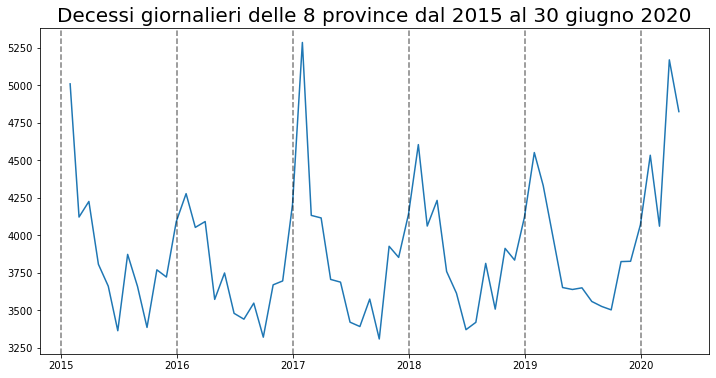

In [6]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico della time series
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi giornalieri delle 8 province dal 2015 al 30 giugno 2020', size=20)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

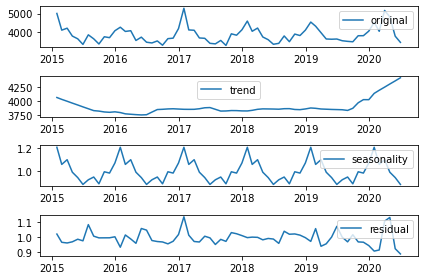

In [7]:
#decomposizione della serie in trend, stagionalità e residui - METODO MOLTIPLICATIVO
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False
        

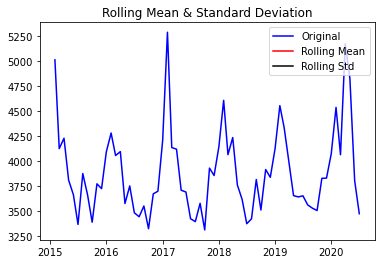

Results of Dickey-Fuller Test:
Test Statistic                 -4.812638
p-value                         0.000051
#Lags Used                      0.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64
X is stationary


True

In [9]:
test_stationarity(ts)

In [10]:
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)


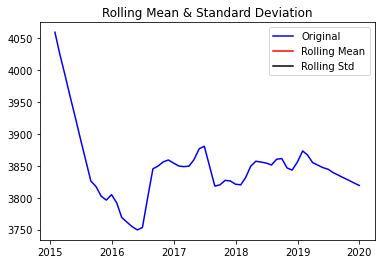

Results of Dickey-Fuller Test:
Test Statistic                 -3.825544
p-value                         0.002657
#Lags Used                     11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64
X is not stationary


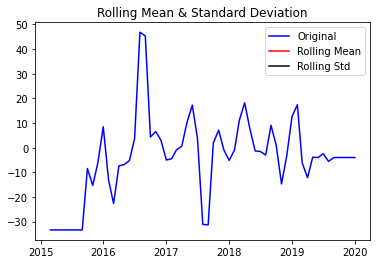

Results of Dickey-Fuller Test:
Test Statistic                 -2.464128
p-value                         0.124448
#Lags Used                     10.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64
X is not stationary


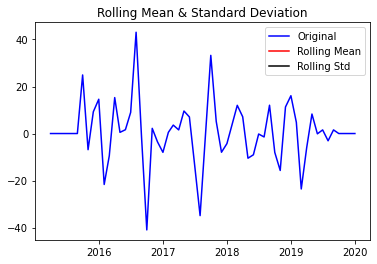

Results of Dickey-Fuller Test:
Test Statistic                 -2.210962
p-value                         0.202291
#Lags Used                      9.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64
X is not stationary


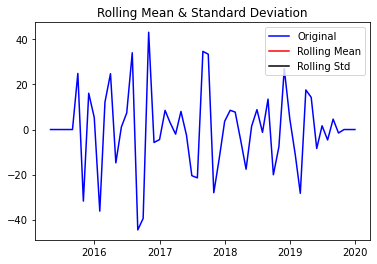

Results of Dickey-Fuller Test:
Test Statistic                -7.428501e+00
p-value                        6.453161e-11
#Lags Used                     8.000000e+00
Number of Observations Used    4.800000e+01
Critical Value (1%)           -3.574589e+00
Critical Value (5%)           -2.923954e+00
Critical Value (10%)          -2.600039e+00
dtype: float64
X is stationary
3


In [11]:
from dateutil.relativedelta import *
tsb = ts[:test_end]
decomposition = seasonal_decompose(tsb, period=12, two_sided=True, extrapolate_trend=1, model='multiplicative')

tsb_trend = decomposition.trend #andamento della curva
tsb_seasonal = decomposition.seasonal #stagionalità 
tsb_residual = decomposition.resid #parti rimanenti


tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1
print(d)

#TEST: dal 01-01-2015 al 31-10-2019
train = tsb[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = tsb[train_end + relativedelta(months=+1): test_end]

In [12]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
nlags = 12
bacf, confint = acf(tsb, alpha=0.1, nlags=nlags)
bpacf, pconfint = pacf(tsb, alpha=0.1, nlags=nlags)
#plt.scatter(np.arange(0,12), bpacf[0:12])
#print(bpacf[0:12])
#print(confint[0:12])
p = 0
q = 0
for i in range(0,nlags):
    c_pacf = bpacf[0:nlags][i]
    c_pconfint = c_pacf - pconfint[0:nlags][i][0]
    #print("cpaf: " + str(c_pacf) + " confint: " + str(c_pconfint))
    if c_pacf > c_pconfint:
        q = i
    
    c_acf = bacf[0:nlags][i]
    c_confint = c_acf - confint[0:nlags][i][0]
    #print("cpaf: " + str(c_acf) + " confint: " + str(c_confint))
    if c_acf > c_confint:
        p = i
print(p)
print(q)

11
1


c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


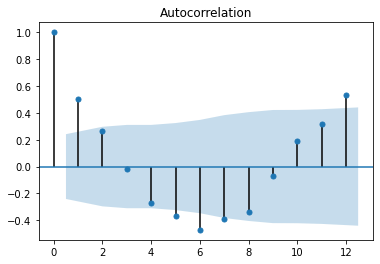

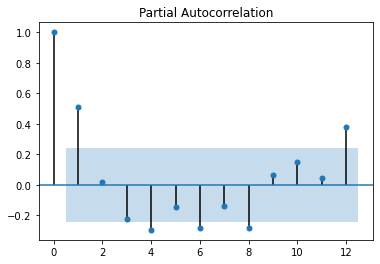

In [13]:
#grafici di autocorrelazione e autocorrelazione parziale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

In [14]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#p = 40
#q = 18
#d = 0
model = SARIMAX(train, order=(11,3,1))
model_fit = model.fit()
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-i

                               SARIMAX Results                                
Dep. Variable:                 TOTALE   No. Observations:                   58
Model:              SARIMAX(11, 3, 1)   Log Likelihood                -391.232
Date:                Fri, 30 Oct 2020   AIC                            808.464
Time:                        16:47:35   BIC                            834.559
Sample:                    01-31-2015   HQIC                           818.555
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0745      0.092    -11.735      0.000      -1.254      -0.895
ar.L2         -1.0315      0.157     -6.571      0.000      -1.339      -0.724
ar.L3         -0.9252      0.209     -4.420      0.0

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


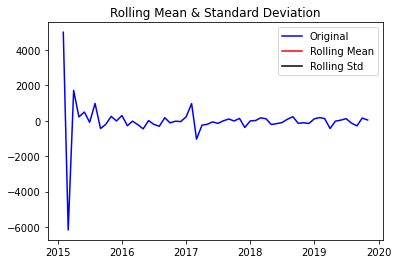

Results of Dickey-Fuller Test:
Test Statistic                -21.809156
p-value                         0.000000
#Lags Used                      0.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64
X is stationary


True

In [15]:
#verifico che i residui del modello siano stazionari
residuals = model_fit.resid
test_stationarity(residuals)

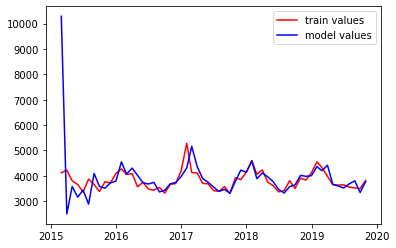

In [16]:
plt.plot (train.iloc[1:], color='red', label='train values')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue', label='model values')

plt.legend()
plt.show()


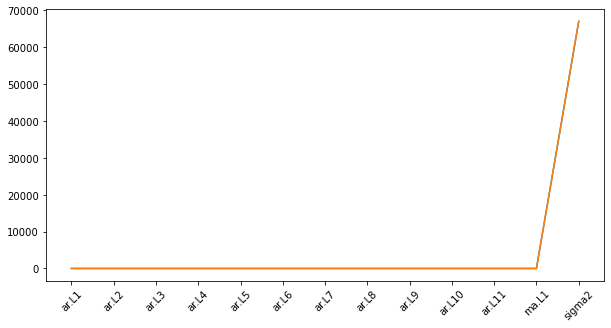

In [17]:
conf = model_fit.conf_int()
plt.figure(figsize=(10,5))
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

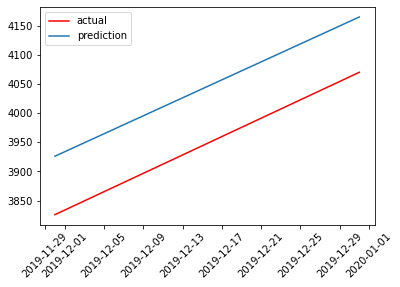

2019-11-30    3926.139277
2019-12-31    4164.785834
Freq: M, Name: predicted_mean, dtype: float64


In [18]:
#inizio e fine predizione
pred_start = test.index[0]
pred_end = test.index[-1]

#pred_start= len(train)
#pred_end = len(tsb)
#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.plot(test, color='red', label='actual')
plt.plot(predictions_test, label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(predictions_test)

In [19]:
pred_start

Timestamp('2019-11-30 00:00:00')

In [20]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.39958731666201536


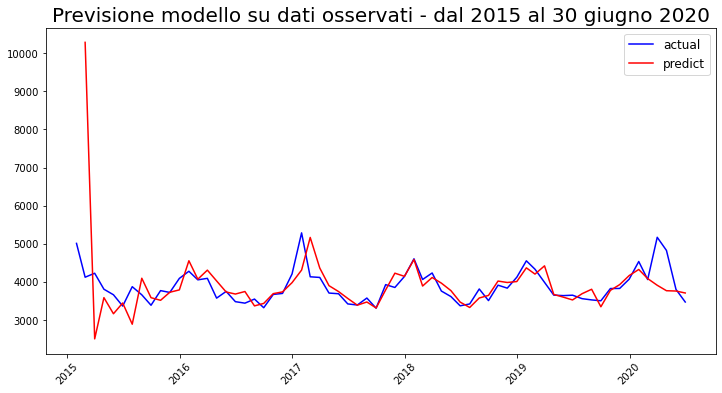

In [21]:
#inizio e fine predizione
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

# predizione sul trend della serie storica includendo il 2020
predictions = model_fit.predict(start=start_prediction, end=end_prediction)

predictions_tot = predictions 

plt.figure(figsize=(12,6))
plt.title('Previsione modello su dati osservati - dal 2015 al 30 giugno 2020', size=20)
plt.plot(ts, color='blue', label='actual')
plt.plot(predictions_tot.iloc[1:], color='red', label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

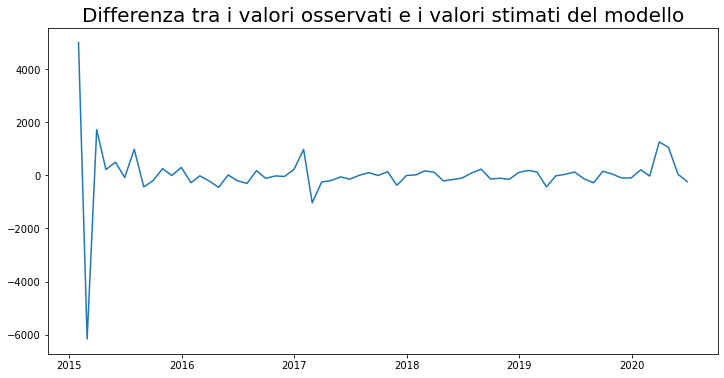

In [22]:
diff_predictions_tot = (ts - predictions_tot)
plt.figure(figsize=(12,6))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot)
plt.show()

In [23]:
diff_predictions_tot['24-02-2020':].sum()

2096.7824443750674

In [24]:
predictions_tot.to_csv('../../csv/pred/predictions_SARIMA_veneto.csv')

In [26]:
forecast = model_fit.get_prediction(start=start_prediction, end=end_prediction)
in_c = forecast.conf_int()
#print(forecast.predicted_mean)
#print(test)
#print(in_c)
print(in_c['upper TOTALE'] - in_c['lower TOTALE'])

2015-01-31    7515.388818
2015-02-28    6050.921399
2015-03-31    2782.392887
2015-04-30    2384.470037
2015-05-31    2051.648797
                 ...     
2020-02-29    2103.888414
2020-03-31    2407.787004
2020-04-30    2702.278090
2020-05-31    2987.877724
2020-06-30    3277.131542
Freq: M, Length: 66, dtype: float64


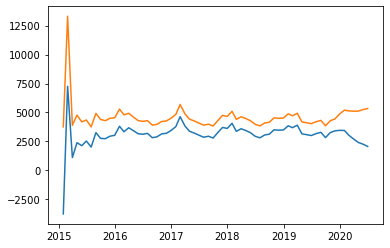

In [28]:
plt.plot(in_c)
plt.show()